# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

In [2]:
mat = loadmat("MR_data.mat")

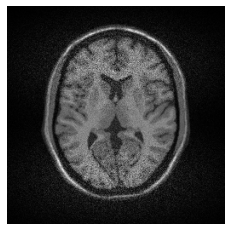

In [3]:
image = mat['I_noisy2']

plt.imshow(image)
plt.axis('off')
plt.gray()
plt.show()

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

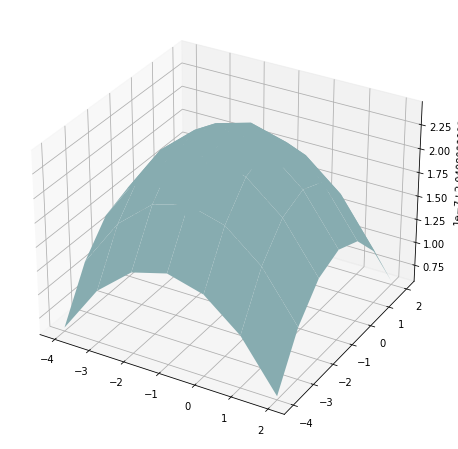

In [4]:
window_size = 7
sigma_s = 1000
sigma_r = 15

def fgaussian(size, sigma):
    m = n = size
    h, k = m//2, n//2
    x, y = np.mgrid[-h:h+1, -k:k+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return g/g.sum() 

def mesh(fun, size):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z, color='powderblue')
    plt.show()

kernel_s = fgaussian(window_size, sigma_s)
# print(kernel_s)
mesh(kernel_s, window_size)

In [5]:
def count_filter(window, kernel):
    '''
        receives window = context around the pixel
        and kernel = matrix of filter coefficients (mask)
        
        returns calculated value for the pixel
    '''
    return np.sum(window*kernel)

def convolution(image, window_size, sigma):
    rows, cols = image.shape
    kernel = fgaussian(window_size, sigma)
    new_image = np.zeros(image.shape)
    
    offset = window_size//2 ## number of pixels from window center to its edge
    
    for i in range(offset, rows - offset):
        for j in range(offset, cols - offset):
            window = image[i-offset:i+offset+1, j-offset:j+offset+1]
            new_image[i, j] = count_filter(window, kernel)
    
    return new_image

In [6]:
def show_filtered(image, filtered):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    for axis in ax: axis.axis('off')

    ax[0].set_title('obraz oryginalny')
    ax[1].set_title('po filtracji')
    ax[2].set_title('moduł z różnicy')

    ax[0].imshow(image, vmin=0, vmax=255)
    ax[1].imshow(filtered, vmin=0, vmax=255)
    ax[2].imshow(5*np.abs(image.astype('int') - filtered.astype('int')), vmin=0, vmax=255)

    plt.show()

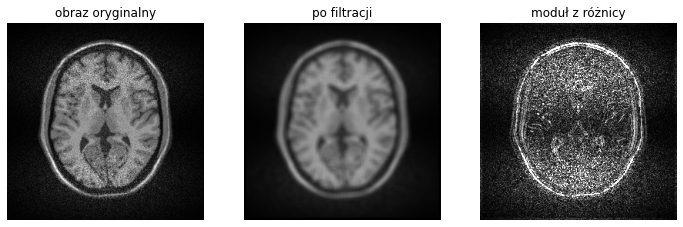

In [7]:
filtered = convolution(image, window_size, sigma_s)
show_filtered(image, filtered)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [8]:
sigma_r = 15

def bilateral(image, window_size, sigma_s, sigma_r):
    rows, cols = image.shape
    new_image = np.zeros(image.shape)
    
    offset = window_size//2
    
    kernel_dist = fgaussian(window_size, sigma_s)
    
    def new_value(window, kernel_dist, sigma_r):
        kernel_value = np.zeros((window_size, window_size))
        
        center_value = window[window_size//2, window_size//2]

        for x in range(window_size):
            for y in range(window_size):
                kernel_value[x, y] = np.exp(-(window[x, y] - center_value)**2/(2*sigma_r**2))

        kernel = kernel_dist * kernel_value
        kernel /= np.sum(kernel)
        
        return count_filter(window, kernel)
        
    for i in range(offset, rows - offset):
        for j in range(offset, cols - offset):
            window = image[i-offset:i+offset+1, j-offset:j+offset+1].astype('float')
            new_image[i, j] = new_value(window, kernel_dist, sigma_r)
    
    return new_image

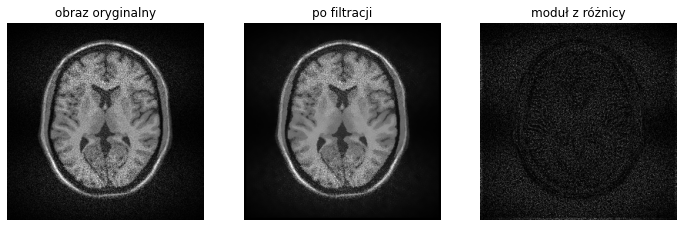

In [9]:
bilateral_filtered = bilateral(image, window_size, sigma_s, sigma_r)
show_filtered(image, bilateral_filtered)

Filtr bilateralny dał lepsze rezultaty od zwykłej konwolucji. Szumy na obrazie zostały w dużym stopniu zredukowane, przy jednoczesnym braku rozmycia krawędzi.

M. Hawryluk, 2022